In [38]:
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm
import librosa

## Loading the dataset and createing train,val,test matrices

In [39]:
base_path = pathlib.Path("./ESC-50-master")
meta_data = pd.read_csv(base_path / "meta/esc50.csv")
audio_folder = base_path / "audio"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
meta_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [41]:
train_file_path_list=[]
val_file_path_list=[]
test_file_path_list=[]
y_train=[]
y_val=[]
y_test=[]
for file in audio_folder.iterdir():
    if file.name in meta_data[meta_data['esc10'] == True]['filename'].to_list():
        if file.name in meta_data[meta_data['fold'].isin([1,2,3]) ]['filename'].to_list():
            train_file_path_list.append(file)
            y_train.append(meta_data[meta_data['filename'] == file.name]['category'].values[0])
        elif file.name in meta_data[meta_data['fold'].isin([4]) ]['filename'].to_list():
            val_file_path_list.append(file)
            y_val.append(meta_data[meta_data['filename'] == file.name]['category'].values[0])
        elif file.name in meta_data[meta_data['fold'].isin([5]) ]['filename'].to_list():
            test_file_path_list.append(file)
            y_test.append(meta_data[meta_data['filename'] == file.name]['category'].values[0])
print("Train files: ", len(train_file_path_list))
print("Validation files: ", len(val_file_path_list))
print("Test files: ", len(test_file_path_list))

Train files:  240
Validation files:  80
Test files:  80


In [42]:
def extract_mel_spectrogram(audio_path, n_mels=128, win_ms=25, hop_ms=10, duration=5, sr=44100):
    
    
    y, sr = librosa.load(audio_path, sr=None, duration=duration)
    win_length = int(win_ms * sr / 1000)
    hop_length = int(hop_ms * sr / 1000)
    
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        win_length=win_length,
        hop_length=hop_length,
    )
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram_db[:,:500] # Dropping the last columns as advised


In [43]:
# Each array is of the shape no of sample ,128, 500
X_train = np.stack([extract_mel_spectrogram(file) for file in train_file_path_list], axis=0)
X_val = np.stack([extract_mel_spectrogram(file) for file in val_file_path_list], axis=0)
X_test = np.stack([extract_mel_spectrogram(file) for file in test_file_path_list], axis=0)

In [44]:
#Mapping the labels to numbers
from sklearn.preprocessing import LabelEncoder
LabelEncoder = LabelEncoder()
y_train = LabelEncoder.fit_transform(y_train)
y_val = LabelEncoder.transform(y_val)
y_test = LabelEncoder.transform(y_test)

In [45]:
len(set(y_train))

10

# Part a A batch size of 16 is used throughout

In [46]:
X_train = torch.tensor(X_train,).unsqueeze(1)
X_val = torch.tensor(X_val).unsqueeze(1)
X_test = torch.tensor(X_test).unsqueeze(1)
y_train ,y_val, y_test = torch.tensor(y_train), torch.tensor(y_val), torch.tensor(y_test)

## Creating datasets and dataloaders
 #TODO Mention in report I have used Relu activation function except for output layer I have used 10 epochs

In [47]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 16
num_epochs = 20
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Creating Model and Trainer Class

In [48]:
class vanilla_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1),padding=(1, 1)) # Maintain the H,W
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),padding=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        
        self.fc1 = nn.Linear(in_features=16*14*55,out_features=128)
        self.logits_layer = nn.Linear(in_features=128, out_features=10)     
    def forward(self,X):
        '''
        X is 16,1,128,500  batch,num_channels, height, width 
        '''
        C1 = self.conv1(X) # 16,16,128,500
        C1 = torch.relu(C1)
        P1 = self.pool1(C1) # 16,16,42,166
        
        C2 = self.conv2(P1) # 16,16,42,166
        C2 = torch.relu(C2)
        P2 = self.pool2(C2) # 16,16,14,55
        P2 = P2.reshape(P2.shape[0], -1) # Flattening the tensor

        F1 = self.fc1(P2) # 16,128
        F1 = torch.relu(F1)
        logits = self.logits_layer(F1) # 16,10
        return logits

In [49]:
class Trainer:
    def __init__(self,model,train_dl,val_dl,test_dl,epochs,optimizer,device):
        self.model = model
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.test_dl = test_dl
        self.epochs = epochs
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = nn.CrossEntropyLoss()
        self.model.to(self.device)
        self.train_loss = []
        self.val_loss = []
    
    def evaluate_loss(self,dl):
        self.model.eval()
        loss = 0
        total_samples = 0
        with torch.no_grad():
            for xb,yb in dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                pred = self.model(xb)
                loss = loss+ self.loss_fn(pred, yb).item()*len(yb)
                total_samples += len(yb)
        return loss/total_samples
    
    
    def train(self):
        self.train_loss.append(self.evaluate_loss(self.train_dl))
        self.val_loss.append(self.evaluate_loss(self.val_dl))
        tqdm.write(f"Initial Train Loss: {self.train_loss[-1]}, Validation Loss: {self.val_loss[-1]}")
        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            for xb,yb in self.train_dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            self.train_loss.append(self.evaluate_loss(self.train_dl))
            self.val_loss.append(self.evaluate_loss(self.val_dl))    
    def plot_loss(self,title):
        plt.plot(self.train_loss, label='Training Loss',marker='*')
        plt.plot(self.val_loss, label='Validation Loss',marker='o')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend()
        plt.savefig(title + ".png")
        plt.show()
    
    def evaluate_accuracy(self,dl):
        self.model.eval()
        correct = 0
        total_samples = 0
        with torch.no_grad():
            for xb,yb in dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                pred = self.model(xb)
                y_pred = torch.argmax(pred, dim=1)
                correct += (y_pred == yb).sum().item()
                total_samples += len(yb)
        return correct/total_samples


## Running the expertiments

Initial Train Loss: 3.4293169816335043, Validation Loss: 3.5413998126983643


100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


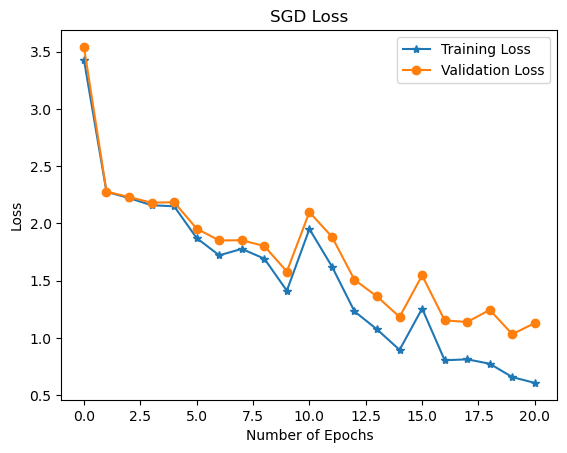

Train Accuracy with SGD: 0.7958333333333333
Validation Accuracy with SGD: 0.65
Test Accuracy with SGD: 0.7


In [50]:
torch.manual_seed(0)
model_sgd = vanilla_cnn()
optimizer = optim.SGD(model_sgd.parameters())
trainer = Trainer(model_sgd,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("SGD Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with SGD: {train_accuracy}")
print(f"Validation Accuracy with SGD: {val_accuracy}")
print(f"Test Accuracy with SGD: {test_accuracy}")

In [51]:
del(trainer)
del(model_sgd)
del(optimizer)

Initial Train Loss: 3.4293169816335043, Validation Loss: 3.5413998126983643


100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


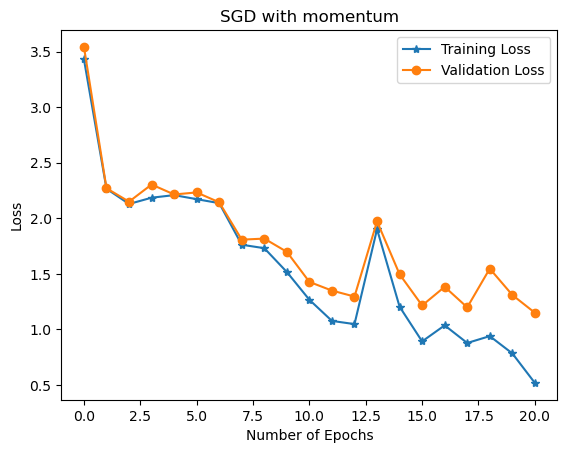

Train Accuracy with SGD with momentum: 0.8333333333333334
Validation Accuracy with SGD with momentum: 0.65
Test Accuracy with SGD with momentum: 0.625


In [52]:
torch.manual_seed(0)
model_sgd_momentum = vanilla_cnn()
optimizer = optim.SGD(model_sgd_momentum.parameters(), momentum=0.9)
trainer = Trainer(model_sgd_momentum,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("SGD with momentum")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with SGD with momentum: {train_accuracy}")
print(f"Validation Accuracy with SGD with momentum: {val_accuracy}")
print(f"Test Accuracy with SGD with momentum: {test_accuracy}")

In [53]:
del(trainer)
del(model_sgd_momentum)
del(optimizer)

Initial Train Loss: 3.4293169816335043, Validation Loss: 3.5413998126983643


100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


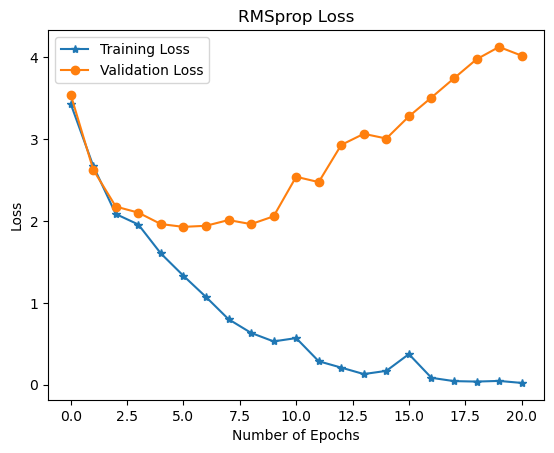

Train Accuracy with RMSprop: 0.9958333333333333
Validation Accuracy with RMSprop: 0.525
Test Accuracy with RMSprop: 0.45


In [54]:
torch.manual_seed(0)
model_rmsprop = vanilla_cnn()
optimizer = optim.RMSprop(model_rmsprop.parameters())
trainer = Trainer(model_rmsprop,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("RMSprop Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with RMSprop: {train_accuracy}")
print(f"Validation Accuracy with RMSprop: {val_accuracy}")
print(f"Test Accuracy with RMSprop: {test_accuracy}")

In [55]:
del(trainer)
del(model_rmsprop)
del(optimizer)

Initial Train Loss: 3.4293169816335043, Validation Loss: 3.5413998126983643


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


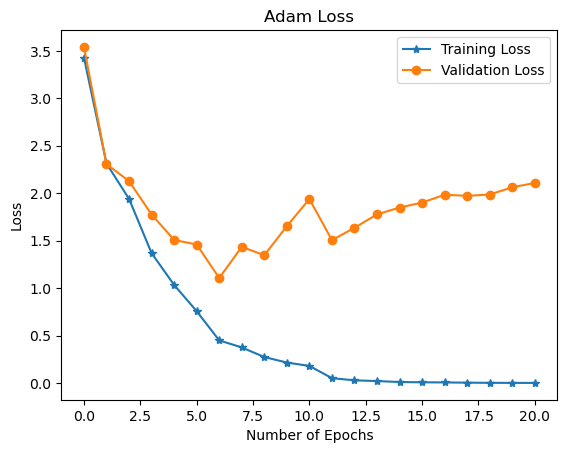

Train Accuracy with Adam: 1.0
Validation Accuracy with Adam: 0.6125
Test Accuracy with Adam: 0.5125


In [56]:
torch.manual_seed(0)
model_adam = vanilla_cnn()
optimizer = optim.Adam(model_adam.parameters())
trainer = Trainer(model_adam,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("Adam Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with Adam: {train_accuracy}")
print(f"Validation Accuracy with Adam: {val_accuracy}")
print(f"Test Accuracy with Adam: {test_accuracy}")

In [57]:
del(trainer)
del(model_adam)
del(optimizer)

# Part B

In [58]:
class normed_cnn(nn.Module):
    def __init__(self,norm_type=None):
        super().__init__()
        self.norm_type = norm_type
        if self.norm_type == "batch":
            self.batch_norm = nn.BatchNorm2d(num_features=16) # Normalization one for each channel across the batch
        elif self.norm_type == "layer":
            self.layer_norm = nn.LayerNorm([14,55]) # Normalization across all in a channel
            
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1),padding=(1, 1)) # Maintain the H,W
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),padding=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        
        self.fc1 = nn.Linear(in_features=16*14*55,out_features=128)
        self.logits_layer = nn.Linear(in_features=128, out_features=10)     
    def forward(self,X):
        '''
        X is 16,1,128,500  batch,num_channels, height, width 
        '''
        C1 = self.conv1(X) # 16,16,128,500
        C1 = torch.relu(C1)
        P1 = self.pool1(C1) # 16,16,42,166
        
        C2 = self.conv2(P1) # 16,16,42,166
        C2 = torch.relu(C2)
        P2 = self.pool2(C2) # 16,16,14,55
        
        if self.norm_type == "batch":
            P2 = self.batch_norm(P2)
        elif self.norm_type == "layer":
            P2 = self.layer_norm(P2)
        
        P2 = P2.reshape(P2.shape[0], -1) # Flattening the tensor

        F1 = self.fc1(P2) # 16,128
        F1 = torch.relu(F1)
        logits = self.logits_layer(F1) # 16,10
        return logits

## Running the experiments for part b

Initial Train Loss: 3.4293169816335043, Validation Loss: 3.5413998126983643


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


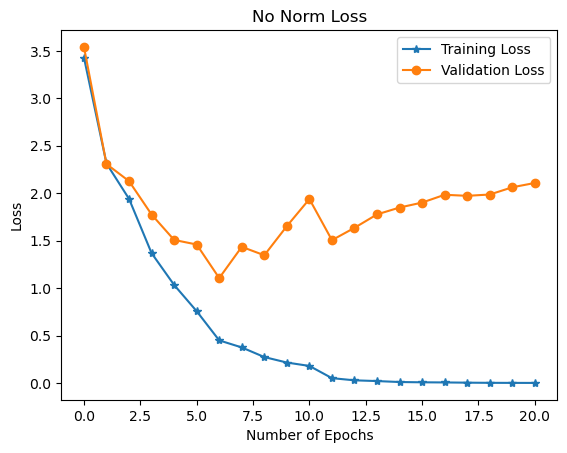

Train Accuracy with No Norm: 1.0
Validation Accuracy with No Norm: 0.6125
Test Accuracy with No Norm: 0.5125


In [59]:
torch.manual_seed(0)
nonorm_model = normed_cnn(norm_type=None)
optimizer = optim.Adam(nonorm_model.parameters())
trainer = Trainer(nonorm_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("No Norm Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with No Norm: {train_accuracy}")
print(f"Validation Accuracy with No Norm: {val_accuracy}")
print(f"Test Accuracy with No Norm: {test_accuracy}")
del(trainer)
del(nonorm_model)
del(optimizer)

Initial Train Loss: 2.313591559727987, Validation Loss: 2.2979125499725344


100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


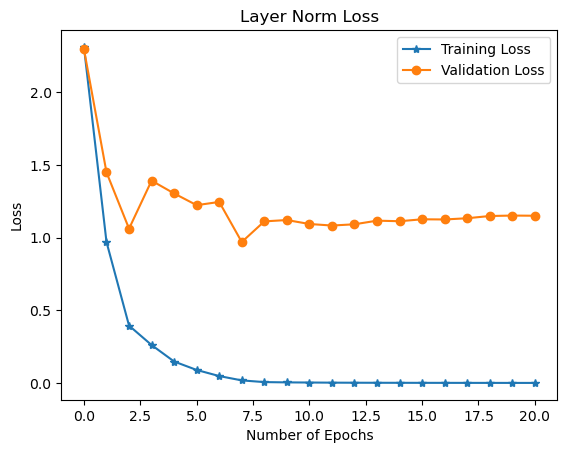

Train Accuracy with Layer Norm: 1.0
Validation Accuracy with Layer Norm: 0.7125
Test Accuracy with Layer Norm: 0.7125


In [60]:
torch.manual_seed(0)
layernorm_model = normed_cnn(norm_type='layer')
optimizer = optim.Adam(layernorm_model.parameters())
trainer = Trainer(layernorm_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("Layer Norm Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with Layer Norm: {train_accuracy}")
print(f"Validation Accuracy with Layer Norm: {val_accuracy}")
print(f"Test Accuracy with Layer Norm: {test_accuracy}")
del(trainer)
del(layernorm_model)
del(optimizer)

Initial Train Loss: 3.429306221008301, Validation Loss: 3.5413880348205566


100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


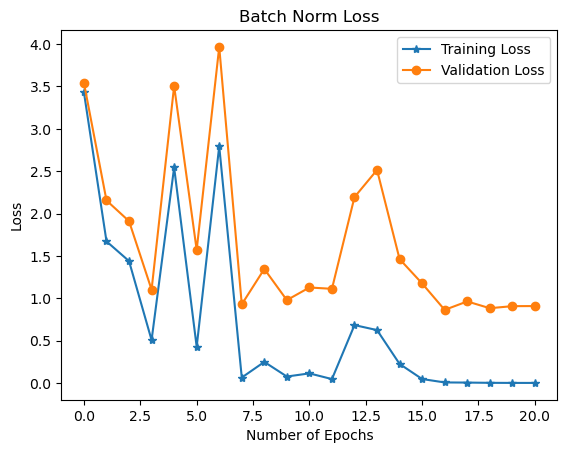

Train Accuracy with Batch Norm: 1.0
Validation Accuracy with Batch Norm: 0.775
Test Accuracy with Batch Norm: 0.7125


In [61]:
torch.manual_seed(0)
batchnorm_model = normed_cnn(norm_type='batch')
optimizer = optim.Adam(batchnorm_model.parameters())
trainer = Trainer(batchnorm_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("Batch Norm Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with Batch Norm: {train_accuracy}")
print(f"Validation Accuracy with Batch Norm: {val_accuracy}")
print(f"Test Accuracy with Batch Norm: {test_accuracy}")
del(trainer)
del(batchnorm_model)
del(optimizer)

# Part C

In [88]:
torch.manual_seed(0)
first_model = normed_cnn(norm_type=None)
first_optimizer = optim.SGD(first_model.parameters())
first_trainer = Trainer(first_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=first_optimizer,device=device)
first_trainer.train()
torch.manual_seed(0)
second_model = normed_cnn(norm_type='batch')
second_optimizer = optim.RMSprop(second_model.parameters())
second_trainer = Trainer(second_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=second_optimizer,device=device)
second_trainer.train()
torch.manual_seed(0)
third_model = normed_cnn(norm_type='layer')
third_optimizer = optim.Adam(third_model.parameters())
third_trainer = Trainer(third_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=third_optimizer,device=device)
third_trainer.train()

Initial Train Loss: 3.4293169816335043, Validation Loss: 3.5413998126983643


100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


Initial Train Loss: 3.429306221008301, Validation Loss: 3.5413880348205566


100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


Initial Train Loss: 2.313591559727987, Validation Loss: 2.2979125499725344


100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


In [89]:
first_model_accuracy = first_trainer.evaluate_accuracy(test_dl)
second_model_accuracy = second_trainer.evaluate_accuracy(test_dl)
third_model_accuracy = third_trainer.evaluate_accuracy(test_dl)
print(f"Test Accuracy first model: {first_model_accuracy}")
print(f"Test Accuracy second model: {second_model_accuracy}")
print(f"Test Accuracy third model: {third_model_accuracy}")

Test Accuracy first model: 0.7
Test Accuracy second model: 0.25
Test Accuracy third model: 0.7125


## Averaging of posterior model outputs

In [90]:
def averaged_prob_model(X):
    first_model.eval()
    second_model.eval()
    third_model.eval()
    return torch.softmax(first_model(X), dim=1) + torch.softmax(second_model(X), dim=1) + torch.softmax(third_model(X), dim=1)
def ensemble_accuracy(dl):
    with torch.no_grad():
        correct = 0
        total_samples = 0
        for xb,yb in dl:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = averaged_prob_model(xb)
            y_pred = torch.argmax(pred, dim=1)
            correct += (y_pred == yb).sum().item()
            total_samples += len(yb)
    return correct/total_samples

In [91]:
print("ensemble_accuracy direct averaging: ", ensemble_accuracy(test_dl))

ensemble_accuracy direct averaging:  0.7375


## Optimal Ensembling using a coorelation matrix

In [92]:
model_list = [first_model, second_model, third_model]

In [96]:
def ensemble_accuracy_weighted(X_test,y_test,error_matrix):
    first_model.eval()
    second_model.eval()
    third_model.eval()
    first_prob = torch.softmax(first_model(X_test), dim=-1).detach().numpy()
    second_prob = torch.softmax(second_model(X_test), dim=-1).detach().numpy()
    third_prob = torch.softmax(third_model(X_test), dim=-1).detach().numpy()
    weights = error_matrix@np.ones(len(error_matrix))
    weights = weights/np.sum(weights)
    print("weights for optimal ensembling: ", weights)
    avg_prob = (first_prob*weights[0] + second_prob*weights[1] + third_prob*weights[2])
    y_pred = np.argmax(avg_prob, axis=1)
    correct = np.sum(y_pred == y_test.numpy())
    total_samples = len(y_test)
    return correct/total_samples

In [97]:
error_matrix = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        model_list[i].eval()
        model_list[j].eval()
        y_pred_i = torch.softmax(model_list[i](X_val),dim=-1) # Calculate the probabilities for model i
        y_pred_j = torch.softmax(model_list[j](X_val),dim=-1)
        i_true_scores = y_pred_i[range(len(y_pred_i)),y_val].reshape(-1).detach().numpy() # Selecting the probabilities of the true classes
        j_true_scores = y_pred_j[range(len(y_pred_j)),y_val].reshape(-1).detach().numpy()
        error_matrix[i,j] = np.dot(i_true_scores,j_true_scores)/len(i_true_scores)
print(error_matrix)

[[0.32396872 0.13511941 0.3679956 ]
 [0.13511941 0.09842855 0.17956531]
 [0.3679956  0.17956531 0.57161145]]


In [98]:
optimal_ensemble_accuracy = ensemble_accuracy_weighted(X_test,y_test,error_matrix)
print("ensemble_accuracy weighted averaging: ", optimal_ensemble_accuracy)

weights for optimal ensembling:  [0.35055288 0.17509479 0.47435233]
ensemble_accuracy weighted averaging:  0.75
